# Define the fundamental functions
### Transformation matrices

In [ ]:
import numpy as np

# Define rotation and translation functions
def rotate_z(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0, 0],
                     [np.sin(theta), np.cos(theta), 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def rotate_x(theta):
    return np.array([[1, 0, 0, 0],
                     [0, np.cos(theta), -np.sin(theta), 0],
                     [0, np.sin(theta), np.cos(theta), 0],
                     [0, 0, 0, 1]])

def rotate_y(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta), 0],
                     [0, 1, 0, 0],
                     [-np.sin(theta), 0, np.cos(theta), 0],
                     [0, 0, 0, 1]])

def translate_x(d):
    return np.array([[1, 0, 0, d],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def translate_y(d):
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, d],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def translate_z(d):
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, d],
                     [0, 0, 0, 1]])

def validate_matrix(matrix):

    tolerance = 1e-12
    # Define a function to check if a value is close to zero within the tolerance
    def is_close_to_zero(value):
        return abs(value) < tolerance

    # Iterate through each element in the matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # If the element is close to zero, set it to zero
            if is_close_to_zero(matrix[i][j]):
                matrix[i][j] = 0



### Symbolic transformation matrices

In [ ]:
import sympy as sp

# Define symbolic rotation and translation functions
def rotate_z_sym(theta):
    return sp.Matrix([
        [sp.cos(theta), -sp.sin(theta), 0, 0],
        [sp.sin(theta), sp.cos(theta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def rotate_x_sym(theta):
    return sp.Matrix([
        [1, 0, 0, 0],
        [0, sp.cos(theta), -sp.sin(theta), 0],
        [0, sp.sin(theta), sp.cos(theta), 0],
        [0, 0, 0, 1]
    ])

def rotate_y_sym(theta):
    return sp.Matrix([
        [sp.cos(theta), 0, sp.sin(theta), 0],
        [0, 1, 0, 0],
        [-sp.sin(theta), 0, sp.cos(theta), 0],
        [0, 0, 0, 1]
    ])

def translate_x_sym(d):
    return sp.Matrix([
        [1, 0, 0, d],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def translate_y_sym(d):
    return sp.Matrix([
        [1, 0, 0, 0],
        [0, 1, 0, d],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def translate_z_sym(d):
    return sp.Matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, d],
        [0, 0, 0, 1]
    ])

def validate_matrix_sym(matrix):
    tolerance = 1e-12
    # Define a function to check if a value is close to zero within the tolerance
    def is_close_to_zero(value):
        return abs(value) < tolerance

    # Iterate through each element in the matrix
    for i in range(matrix.rows):
        for j in range(matrix.cols):
            # If the element is close to zero, set it to zero
            if is_close_to_zero(matrix[i, j]):
                matrix[i, j] = 0


# Solving dynamics


$$M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + g(q) = \tau$$

The steps of solving Dynamics are as follows:

1) Let's find **inertia matrix** $M$
$$M(q) = \sum_{i=1}^{n} m_i J_{v_i}^T J_{v_i} + J_{\omega_i}^T R_i I_i R_i^T J_{\omega_i}$$
   - Find COM
   - calculate inertia matrix $I$ (let's assume that the links are cylidrical, so the inertia matrix for each  link is the inertia matrix for a cylinder).
   - calculate the jacobians of the COM:
     - J_v
$$
J_v = \begin{bmatrix}
\frac{\partial p_x}{\partial q_1} & \frac{\partial p_x}{\partial q_2} & \cdots & \frac{\partial p_x}{\partial q_n} \\
\frac{\partial p_y}{\partial q_1} & \frac{\partial p_y}{\partial q_2} & \cdots & \frac{\partial p_y}{\partial q_n} \\
\frac{\partial p_z}{\partial q_1} & \frac{\partial p_z}{\partial q_2} & \cdots & \frac{\partial p_z}{\partial q_n}
\end{bmatrix}
$$

    - J_w

    $$
    J_{w1} = [z_1 \dots] \\
    J_{w2} = [z_1 z_2 \dots] \\
    \dots
    $$



   - calculate rotation matrices for each link

2) Calculate **Coriolis matrix** $C$ (for this we need the inertia matrix M.
$$ c_{ijk} = \frac{\partial m_{ij}}{\partial q_k} + \frac{\partial m_{ik}}{\partial q_j} - \frac{\partial m_{jk}}{\partial q_i} $$

3) Calculate **gravity matrix** g
$$g_i = - \sum_{k} (J_{v_i}^k)^T m_k g$$




### Define the Manipulator class

In [ ]:
import numpy as np

class Manipulator:
    def __init__(self, l, m=[1 for _ in range(6)], r=[0.05 for _ in range(6)]):
        self.l = l # length of the links
        self.m = m # mass of the links
        self.q = None # configuration parameters (angles)
        self.prev_q = None # the previous configuration state
        self.r = r # radii of cylindrical links
        self.h = l  # heights of cylindrical links
        self.lc = [l_i / 2 for l_i in l]  # distances to the links' CoMs

    def set_config(self, q_):
        if self.q is None:
            self.q = q_ if isinstance(q_, list) else [q_]
        else:
            self.prev_q = self.q
            self.q.extend(q_ if isinstance(q_, list) else [q_])

    def get_config(self):
        return self.q

    def get_config_in_pi(self):
        return [str(q_ / np.pi) + "pi" for q_ in self.q]

    def set_prev_config(self, prev_q_):
        if self.prev_q is None:
            self.prev_q = prev_q_ if isinstance(prev_q_, list) else [prev_q_]
        else:
            raise ValueError("Previous configuration is already set. Cannot set again.")

    def get_prev_config(self):
        if self.prev_q is None:
            raise ValueError("Previous configuration is not set.")
        else:
            return self.prev_q

    def get_delta_q(self):
        if self.q is None or self.prev_q is None:
            raise ValueError("Error! Set a proper configuration")
        else:
            delta_q = [q_ - q_prev_ for (q_, q_prev_) in zip(self.q, self.prev_q)]
            return delta_q

    def get_delta_q_in_pi(self):
        if self.q is None or self.prev_q is None:
            raise ValueError("Error! Set a proper configuration")
        else:
            delta_q_pi = [(q_ - q_prev_) / np.pi for (q_, q_prev_) in zip(self.q, self.prev_q)]
            return delta_q_pi

    def get_prev_config_in_pi(self):
        if self.prev_q is None:
            raise ValueError("Previous configuration is not set.")
        else:
            return [q_prev_ / np.pi for q_prev_ in self.prev_q]

In [ ]:
# Example of usage
l = [1 for _ in range(6)]
m = [1 for _ in range(6)]
q = [np.pi/2, np.pi/3, np.pi/4, 0, np.pi/12, 0]
q_prev = [np.pi/2, np.pi/6, np.pi/4, np.pi/12, np.pi/12, 0]

manipulator = Manipulator(l, m)
manipulator.set_config(q)
manipulator.set_prev_config(q_prev)

print(manipulator.get_config())
print(manipulator.get_prev_config())
print("delta q: ", manipulator.get_delta_q_in_pi())

[1.5707963267948966, 1.0471975511965976, 0.7853981633974483, 0, 0.2617993877991494, 0]
[1.5707963267948966, 0.5235987755982988, 0.7853981633974483, 0.2617993877991494, 0.2617993877991494, 0]
delta q:  [0.0, 0.16666666666666666, 0.0, -0.08333333333333333, 0.0, 0.0]


### Find the center of mass


In [ ]:
from sympy import symbols

def calculate_com_symb(manipulator: Manipulator):
    theta1, theta2, theta3, theta4, theta5, theta6 = symbols('theta1 theta2 theta3 theta4 theta5 theta6')
    lc1, lc2, lc3, lc4, lc5, lc6 = manipulator.lc
    l1, l2, l3, l4, l5, l6 = manipulator.l

    T_0 = np.identity(4)
    T_01 = rotate_z_sym(theta1) @ translate_z(l1) @ rotate_z(np.pi/2) @ rotate_x(np.pi/2)
    T_12 = rotate_z_sym(theta2) @ translate_x(l2)
    T_23 = rotate_z_sym(theta3) @ translate_x(l3) @ rotate_y(np.pi/2) @ rotate_z(np.pi/2)
    T_34 = rotate_z_sym(theta4) @ translate_z(l4) @ rotate_x(-np.pi/2) @ rotate_z(-np.pi)
    T_45 = rotate_z_sym(theta5) @ translate_y(l5) @ rotate_x(-np.pi/2)
    T_56 = rotate_z_sym(theta6) @ translate_z(l6)


    com1 = T_0 @ rotate_z_sym(theta1) @ translate_z(lc1) @ rotate_z(np.pi/2) @ rotate_x(np.pi/2)

    T_01 = T_0 @ T_01
    com2 = T_01 @ rotate_z_sym(theta2) @ translate_x(lc2)

    T_02 = T_01 @ T_12
    com3 = T_02 @ rotate_z_sym(theta3) @ translate_x(lc3) @ rotate_y(np.pi/2) @ rotate_z(np.pi/2)

    T_03 = T_02 @ T_23
    com4 = T_03 @ rotate_z_sym(theta4) @ translate_z(lc4) @ rotate_x(-np.pi/2) @ rotate_z(-np.pi)

    T_04 = T_03 @ T_34
    com5 = T_04 @ rotate_z_sym(theta5) @ translate_y(lc5) @ rotate_x(-np.pi/2)

    T_05 = T_04 @ T_45
    com6 = T_05 @ rotate_z_sym(theta6) @ translate_z(lc6)

    coms = [com1, com2, com3, com4, com5, com6]
    return coms


coms_matrices_symb = calculate_com_symb(manipulator)
# coms_matrices_symb #  too long to print

### Calculate inertia/mass matrices assuming that the manipulator's links are cylindrical

In [ ]:
class InertiaMatrixForCylinder:
    def __init__(self, m, r, h):
        self.m = m
        self.r = r
        self.h = h

    def compute(self):
        I = np.array([[self.m*self.h**2/12 + self.m*self.r**2/4, 0, 0],
                      [0, self.m*self.h**2/12 + self.m*self.r**2/4, 0],
                      [0, 0, self.m*self.r**2/4]])
        return I


### Calculate the Jacobian J_v




In [ ]:
def calculate_jacobian_v(com_symb):

  q1_symb, q2_symb, q3_symb, q4_symb, q5_symb, q6_symb = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6')
  q_symb = [q1_symb, q2_symb, q3_symb, q4_symb, q5_symb, q6_symb]

  Jv = np.zeros((6,3,6), object)
  for n in range(6):
    for i in range(3):
      for j in range(6):
        Jv[n][i, j] = sp.diff(com_symb[n][i, 3], q_symb[j])

  return sp.Array(Jv)


Jv = calculate_jacobian_v(coms_matrices_symb)
Jv

[[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], [[0.5*(-6.12323399573677e-17*sin(theta1) - 1.0*cos(theta1))*cos(theta2) + 0.5*(6.12323399573677e-17*sin(theta1) - 3.74939945665464e-33*cos(theta1))*sin(theta2), -0.5*(-1.0*sin(theta1) + 6.12323399573677e-17*cos(theta1))*sin(theta2) + 0.5*(-3.74939945665464e-33*sin(theta1) - 6.12323399573677e-17*cos(theta1))*cos(theta2), 0, 0, 0, 0], [0.5*(-1.0*sin(theta1) + 6.12323399573677e-17*cos(theta1))*cos(theta2) + 0.5*(-3.74939945665464e-33*sin(theta1) - 6.12323399573677e-17*cos(theta1))*sin(theta2), 0.5*(-6.12323399573677e-17*sin(theta1) + 3.74939945665464e-33*cos(theta1))*cos(theta2) - 0.5*(6.12323399573677e-17*sin(theta1) + 1.0*cos(theta1))*sin(theta2), 0, 0, 0, 0], [0, 0.5*cos(theta2), 0, 0, 0, 0]], [[0.5*(-(-6.12323399573677e-17*sin(theta1) - 1.0*cos(theta1))*sin(theta2) + (6.12323399573677e-17*sin(theta1) - 3.74939945665464e-33*cos(theta1))*cos(theta2))*sin(theta3) + 0.5*((-6.12323399573677e-17*sin(theta1) - 1.0*cos(theta1))*co

### Calculate the Jacobian J_w




In [ ]:
def calculate_jacobian_w(com_symb):
    jacobian_w = np.zeros((6, 3, 6), object)
    u = [np.array([[0], [0], [1]]),  com_symb[0][:3, 2],  com_symb[1][:3, 2], com_symb[2][:3, 2],  com_symb[3][:3, 2],  com_symb[4][:3, 2]]
    for i in range(6):
      for j in range(i+1):
        nt = np.array(u[j].tolist())
        jacobian_w[i][:, j] = np.transpose(nt)[0] #u[j].tolist()[:]
    return sp.Array(jacobian_w)

Jw = calculate_jacobian_w(coms_matrices_symb)
Jw

[[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [[0, 6.12323399573677e-17*sin(theta1) + 1.0*cos(theta1), 0, 0, 0, 0], [0, 1.0*sin(theta1) - 6.12323399573677e-17*cos(theta1), 0, 0, 0, 0], [1, 6.12323399573677e-17, 0, 0, 0, 0]], [[0, 6.12323399573677e-17*sin(theta1) + 1.0*cos(theta1), 6.12323399573677e-17*sin(theta1) + 1.0*cos(theta1), 0, 0, 0], [0, 1.0*sin(theta1) - 6.12323399573677e-17*cos(theta1), 1.0*sin(theta1) - 6.12323399573677e-17*cos(theta1), 0, 0, 0], [1, 6.12323399573677e-17, 6.12323399573677e-17, 0, 0, 0]], [[0, 6.12323399573677e-17*sin(theta1) + 1.0*cos(theta1), 6.12323399573677e-17*sin(theta1) + 1.0*cos(theta1), 1.0*(-(-1.0*sin(theta1) + 6.12323399573677e-17*cos(theta1))*sin(theta2) + (-3.74939945665464e-33*sin(theta1) - 6.12323399573677e-17*cos(theta1))*cos(theta2))*sin(theta3) + 1.0*((-1.0*sin(theta1) + 6.12323399573677e-17*cos(theta1))*cos(theta2) + (-3.74939945665464e-33*sin(theta1) - 6.12323399573677e-17*cos(theta1))*sin(theta2))*cos(theta3) + 3.74939945

In [ ]:
def define_R(com_symb):
    R = np.zeros((6, 3, 3), object)
    for n in range(6):
        R[n] = com_symb[n][:3, :3]
    return R

R = define_R(coms_matrices_symb)

# Calculate Mass (Inertia) Matrix

In [ ]:
class MassMatrix:
  def __init__(self, manipulator, com_symb):
    self.manipulator = manipulator
    self.com_symb = com_symb

  def compute_symb(self):
    M = np.zeros((6, 6), object)
    for i in range(6):
      m_i = manipulator.m[i]
      Jv = calculate_jacobian_v(self.com_symb)[i]
      Jw = calculate_jacobian_w(self.com_symb)[i]
      R = define_R(self.com_symb)[i]
      I_m = InertiaMatrixForCylinder(m_i, manipulator.r[i], manipulator.h[i])
      I = I_m.compute()

      M += m_i * np.transpose(Jv) @ Jv + np.transpose(Jw) @ R @ I @ np.transpose(R) @ Jw
    return M

mass_matrix = MassMatrix(manipulator, coms_matrices_symb).compute_symb()


## Calculate Coriolis matrix

In [ ]:
class CorMatrix:

  def __init__(self, mass_matrix):
    self.manipulator = manipulator
    self.M = mass_matrix

  def compute_symb(self):
    dq = sp.symbols('dtheta1 dtheta2 dtheta3 dtheta4 dtheta5 dtheta6')
    q = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6')

    C = np.zeros((6, 6), object)
    for i in range(6):
      for j in range(6):
        for k in range(6):
          c_ijk = 0.5 * (sp.diff(self.M[i,j], q[k]) + sp.diff(self.M[i,k], q[j]) - sp.diff(self.M[j,k], q[i]))
          C[i, j] += c_ijk * dq[k]
    return C

cor_matrix = CorMatrix(mass_matrix).compute_symb()


# Calculate gravity matrix

In [ ]:
class GravityMatrix:
  def __init__(self, jacobian_v):
    self.jacobian_v = jacobian_v
    self.G_CONST = 9.81

  def compute_symb(self):
    G = np.zeros(6, object)
    Jv = self.jacobian_v

    for i in range(6):
      for k in range(6):
        G[i] -= np.dot(Jv[k, :, i], m[k] * np.array([0, 0, self.G_CONST]))

    return sp.Array(G)

grav_matrix = GravityMatrix(Jv).compute_symb()

# **Solve numerically**

In [ ]:
class DynamicsNumericalSolver:
    def __init__(self, q, dq):
        self.q = q
        self.dq = dq
        self.q_sym = sp.symbols('theta1 theta2 theta3 theta4 theta5 theta6')
        self.dq_sym = sp.symbols('dtheta1 dtheta2 dtheta3 dtheta4 dtheta5 dtheta6')

    def subs_symbols(self, expr, symbols, values):
        return expr.subs(list(zip(symbols, values)))

    def calc_M_num(self, M):
        M_num = np.zeros((6, 6))
        for i in range(6):
            for j in range(6):
                M_num[i, j] = self.subs_symbols(M[i, j], self.q_sym, self.q).evalf()
        return M_num

    def calc_C_num(self, C):
        C_num = np.zeros((6, 6))
        for i in range(6):
            for j in range(6):
                C_num[i, j] = self.subs_symbols(C[i, j], self.q_sym + self.dq_sym, self.q + self.dq).evalf()
        return C_num

    def calc_G_num(self, G):
        G_num = np.zeros(6)
        for i in range(6):
            G_num[i] = self.subs_symbols(G[i], self.q_sym, self.q).evalf()
        return G_num

q = [np.pi/2, -np.pi/12, -np.pi/12, np.pi/4, np.pi/6, 0]
dq = [np.pi/24, -np.pi/24, -np.pi/24, np.pi/24, np.pi/24, -np.pi/24]
sol = DynamicsNumericalSolver(q, dq)

mm = sol.calc_M_num(mass_matrix)
cm = sol.calc_C_num(cor_matrix)
gm = sol.calc_G_num(grav_matrix)

mm

array([[ 3.47889606e+01,  1.04577703e+00,  8.62764329e-01,
        -2.99080185e+00, -4.93809167e+00, -7.92665525e-05],
       [ 1.04577703e+00,  3.94428621e+01,  2.75406368e+01,
        -2.91372285e+00,  5.77782346e+00,  2.20970869e-04],
       [ 8.62764329e-01,  2.75406368e+01,  1.98890366e+01,
        -2.23071014e+00,  4.33599171e+00,  2.20970869e-04],
       [-2.99080185e+00, -2.91372285e+00, -2.23071014e+00,
         7.51875000e-01,  8.67361738e-17,  5.41265877e-04],
       [-4.93809167e+00,  5.77782346e+00,  4.33599171e+00,
         7.70899661e-17,  2.66791667e+00,  6.12329750e-18],
       [-7.92665525e-05,  2.20970869e-04,  2.20970869e-04,
         5.41265877e-04,  7.03376159e-18,  6.25000000e-04]])

# **Trajectory planning**

In [ ]:
import matplotlib.pyplot as plt


class TrajectoryTypeChecker:
    """
    The wrapper-class for determining the type of trajectory (triangular or
    trapezoidal based on the given joint parameters.
    """
    def __init__(self):
        pass

    def check_traj_type(self, q_params, t0=0):
        q0, qf, dq_max, ddq_max = q_params
        delta_q = qf - q0

        if np.sqrt(delta_q*ddq_max) <= dq_max:
            return "Triangular"
        else:
            return "Trapezoidal"


class TrajectoryTimeCalculator:
    """
    The wrapper-class for calculating time parameters (tau, T, tf)
    for different types of trajectories.
    """
    def __init__(self):
        self.checker = TrajectoryTypeChecker()

    def calc_traj_time(self, q_params, t0=0):
        q0, qf, dq_max, ddq_max = q_params
        delta_q = qf - q0

        if self.checker.check_traj_type(q_params) == "Triangular":
            tau = delta_q / dq_max
            T = tau
            tf = 2 * tau
        else:
            T = delta_q / dq_max
            tau = dq_max / ddq_max
            tf = T + tau

        return 0, tau, T, tf

class TimeSynchronizer:
    def __init__(self):
        pass

    def sync_time(self, t_params_list):
        t0_sync, t_total, t_dwel = 0, 0, 0

        for t_params in t_params_list:
            t0, tau, T, tf = t_params
            t0_sync = max(t0_sync, t0)
            t_total = max(t_total, tf - t0)
            t_dwel = max(t_dwel, T - tau)

        t0_sync, tf_sync = t0_sync, t0_sync + t_total
        tau_sync = t0 + (t_total - t_dwel) / 2
        T_sync = tau_sync + t_dwel

        return t0_sync, tau_sync, T_sync, tf_sync


class TrapezoidalTrajectoryPlanner:
    def __init__(self):
        pass

    def plan_trajectory(self, t_params, q_params):
        q0, qf, dq_max, ddq_max = q_params
        t0, tau, T, tf = t_params
        t = np.linspace(t0, tf, int(3e3))

        dq_max = min(dq_max, (qf - q0) / T)
        q, dq, ddq = [], [], []
        dq_i, ddq_i = 0, 0
        # q_03, dq03 = 0, 0

        for i in t:
            t_i = i
            q_i = q0

            if 0 < t_i <= tau:

                q_i = q0 + 1/2*ddq_max*(t_i-t0)**2
                q02 = q_i
                dq_i = min(ddq_max * t_i, dq_max)
                dq02 = dq_i
                ddq_i = ddq_max

            elif tau < t_i and t_i <= T:
            # elif tau < t_i and t_i <= (tf - tau):

                q_i = q02 + dq02*(t_i-tau)
                q_03 = q_i
                dq_i = dq_max
                dq03 = dq_i
                ddq_i = 0


            elif t_i > T:
            # elif t_i > (tf - tau):

                q_i = q_03 + dq03*(t_i-T) - 1/2*ddq_max*(t_i-T)**2
                dq_i = min(ddq_max*(tf-t_i), dq_max)
                ddq_i = -ddq_max

            q.append(q_i)
            dq.append(dq_i)
            ddq.append(ddq_i)

        return t, q, dq, ddq


In [ ]:
def plan_sync_trajectory(q_params_list):
    '''
    The main function to create a synchronized trajectory
    '''
    calc_traj = TrajectoryTimeCalculator()
    time_params = [calc_traj.calc_traj_time(j) for j in q_params_list]

    def time_synchronize(t_params):
      synchronizer = TimeSynchronizer()
      t_params_sync = synchronizer.sync_time(t_params)
      return t_params_sync

    t_params_sync = time_synchronize(time_params)

    sync_traj_joints = []
    planner = TrapezoidalTrajectoryPlanner()
    for q_params in q_params_list:
      # print("q_params", q_params)
      sync_traj = planner.plan_trajectory(t_params_sync, q_params)
      sync_traj_joints.append(sync_traj)

    return sync_traj_joints


def plot_trajectory(solution):
    for i in range(len(solution)):
        t, q, dq, ddq = solution[i]

        # Create a new figure for each solution
        plt.figure(figsize=(6, 8))

        # Plot joint positions
        plt.subplot(311)
        plt.plot(t, q)
        plt.title(f"Joint Positions for Solution {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Position")
        plt.grid(True)

        # Plot joint velocities
        plt.subplot(312)
        plt.plot(t, dq)
        plt.title(f"Joint Velocities for Solution {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Velocity")
        plt.grid(True)

        # Plot joint accelerations
        plt.subplot(313)
        plt.plot(t, ddq)
        plt.title(f"Joint Accelerations for Solution {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Acceleration")
        plt.grid(True)

        # Show the plots
        plt.tight_layout()
        plt.show()


Let's set the parameters in the form: $[q_0, q_f, \dot q_m, \ddot q_m]$.

And let's check whether they satisfy the trapezoidal trajectories.


In [ ]:
j1 = [0, np.pi/3,     1,   4]
j2 = [0, np.pi/12,    1,   4]
j3 = [0, np.pi/6,   1.5, 4.5]
j4 = [0, np.pi/8,     1, 3.5]
j5 = [0, np.pi/6,   1.5,   5]
j6 = [0, np.pi/3,     2,   4]

# j1 = [0, np.pi/3, 8, 4]
# j2 = [0, np.pi/12, 4, 2]
# j3 = [0, np.pi/6, 4, 2]
# j4 = [0, np.pi/8, 4, 2]
# j5 = [0, np.pi/6, 3, 2]
# j6 = [0, np.pi/3, 5, 2]

j_s = [j1, j2, j3, j4, j5, j6]

for j in j_s:
  print(TrajectoryTypeChecker().check_traj_type(j))

Trapezoidal
Trapezoidal
Trapezoidal
Trapezoidal
Trapezoidal
Trapezoidal


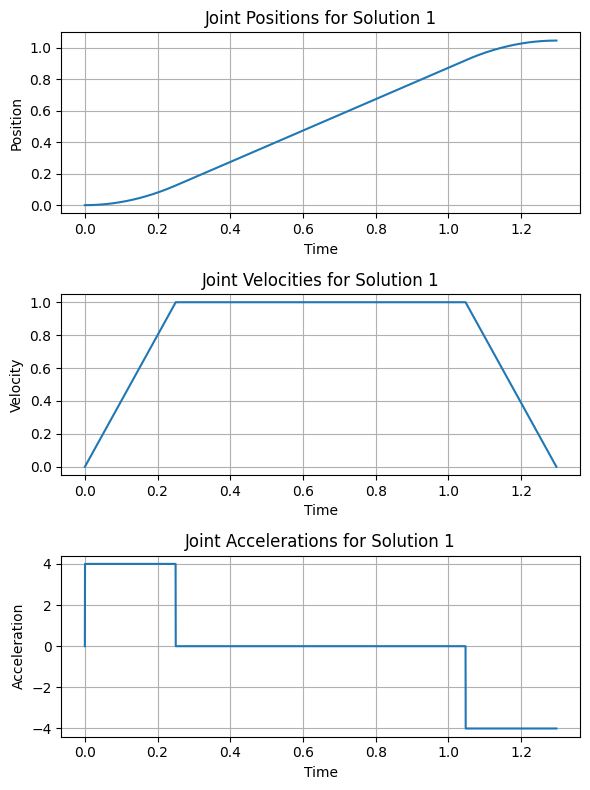

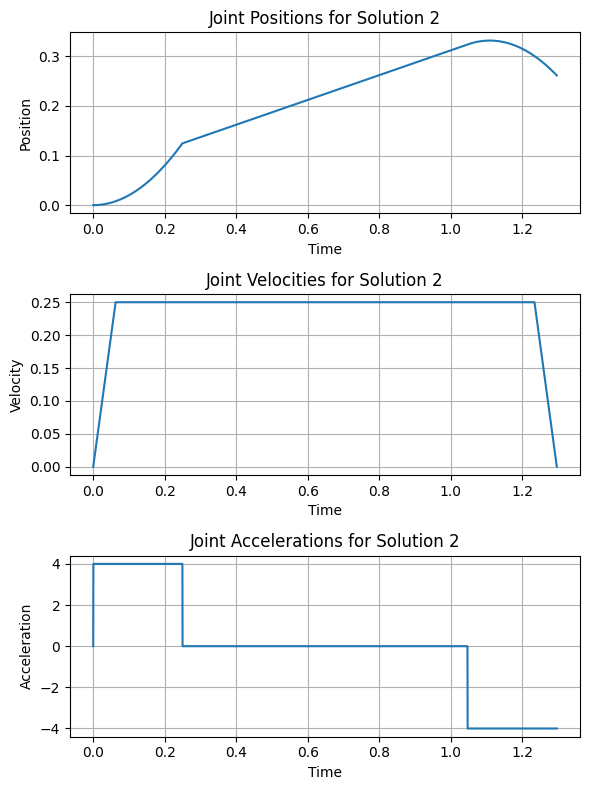

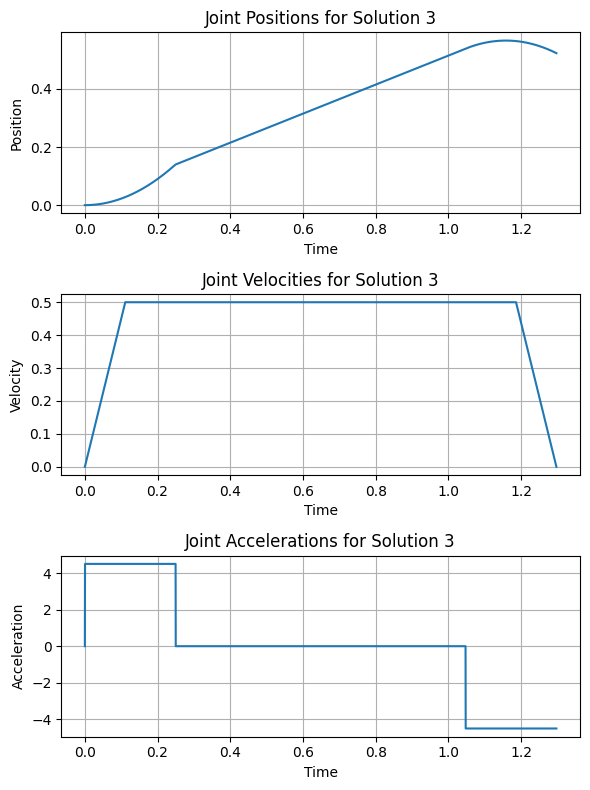

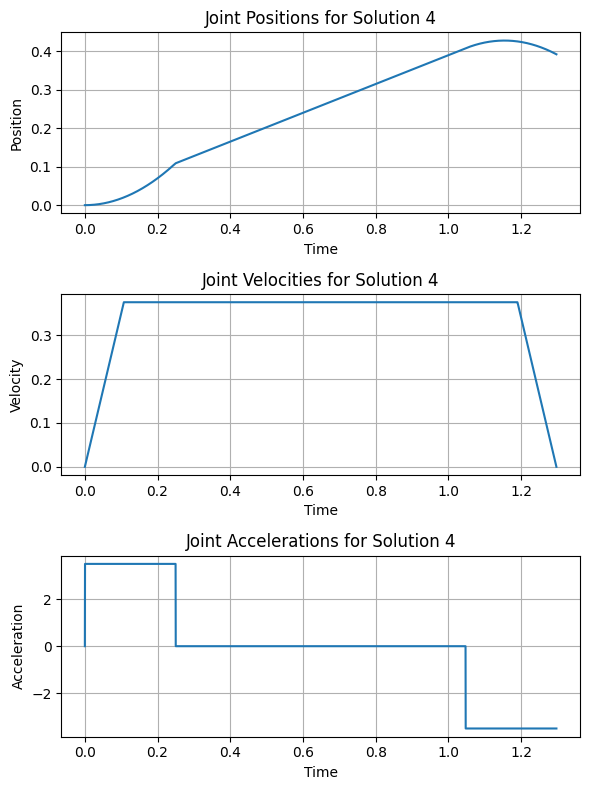

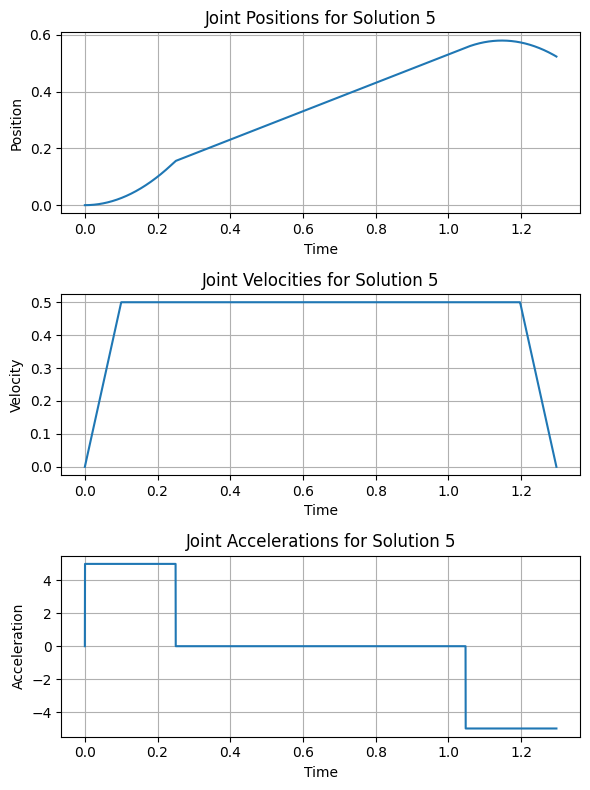

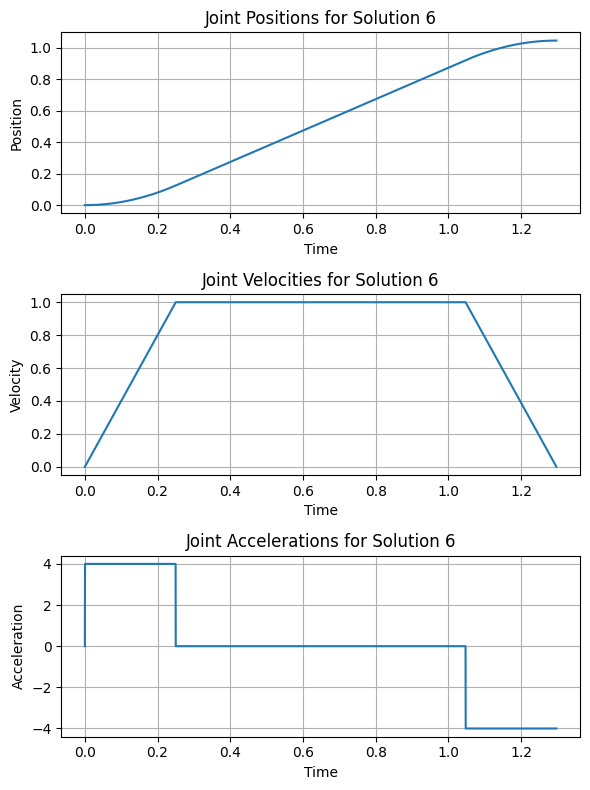

In [ ]:
# Example usage

# Define the params [q0, qf, dq_m, ddq_m]
# j1 = [0, np.pi/3, 8, 4]
# j2 = [0, np.pi/12, 4, 2]
# j3 = [0, np.pi/6, 4, 2]
# j4 = [0, np.pi/8, 4, 2]
# j5 = [0, np.pi/6, 3, 2]
# j6 = [0, np.pi/3, 5, 2]

# j1 = [0,90,8,4]
# j2 = [0,60,4,2]
# j3 = [0,62,4,2]
# j4 = [0,60,4,2]
# j5 = [0,60,3,2]
# j6 = [0,60,5,2]

j1 = [0, np.pi/3,     1,   4]
j2 = [0, np.pi/12,    1,   4]
j3 = [0, np.pi/6,   1.5, 4.5]
j4 = [0, np.pi/8,     1, 3.5]
j5 = [0, np.pi/6,   1.5,   5]
j6 = [0, np.pi/3,     2,   4]

# j1 = [0, 3,   1,   4]
# j2 = [0, 1,   1.5, 3]
# j3 = [0, 2,   2,   4]
# j4 = [0, 2.5, 1.5, 2]
# j5 = [0, 1,   1.5, 3]
# j6 = [0, 2.5, 2,   4]

j_list = [j1, j2, j3, j4, j5, j6]

solution = plan_sync_trajectory(j_list)
plot_trajectory(solution)

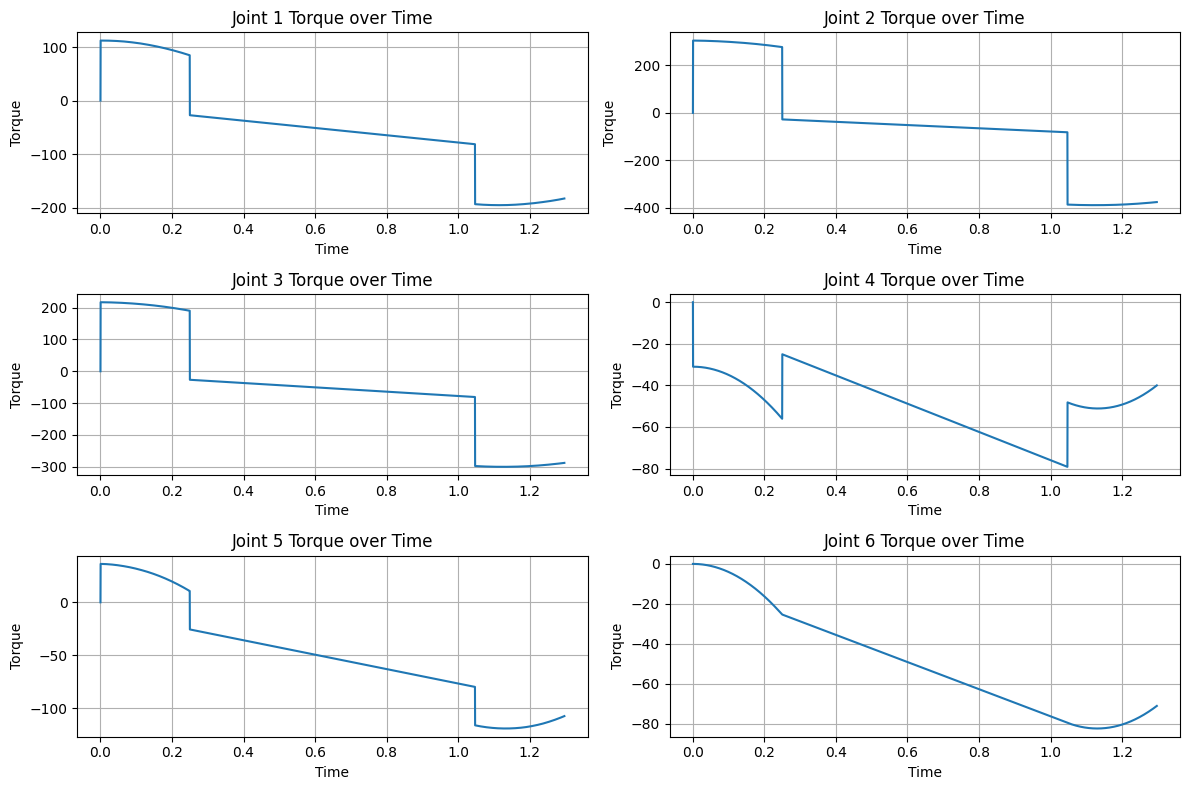

In [ ]:
import matplotlib.pyplot as plt

q_s, dq_s, ddq_s = [], [], []

for i in range(len(solution)):
  t, q, dq, ddq = solution[i]
  q_s.append(q)
  dq_s.append(dq)
  ddq_s.append(ddq)

# def plot_dynamics(dq, ddq, M):
#   for i in range(3000):


m_ddq = mm @ ddq_s
c_dq = cm @ dq_s
g_q = gm @ q_s
tau = m_ddq + c_dq + g_q

# Plotting joint torques
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.plot(t, tau[i])
    plt.title(f'Joint {i+1} Torque over Time')
    plt.xlabel('Time')
    plt.ylabel('Torque')
    plt.grid(True)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

# Bonus task

##Drive the robot between two points using a polynomial profile.


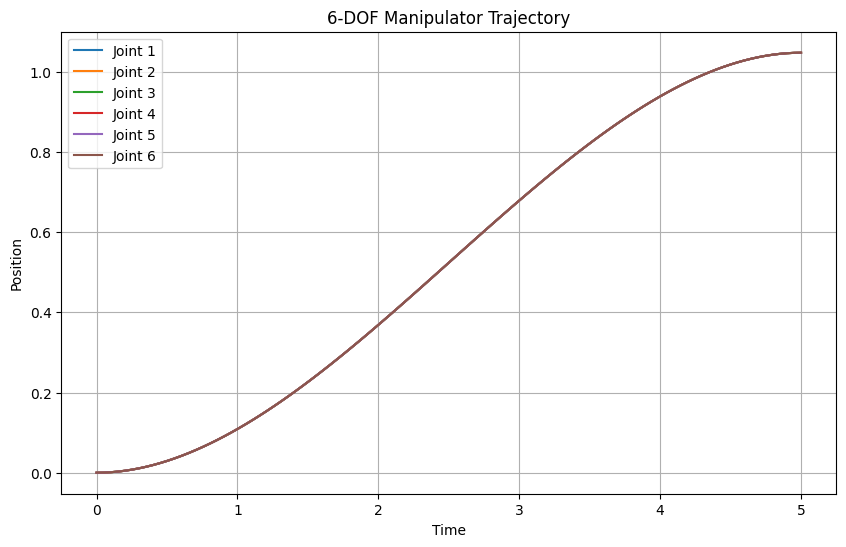

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cubic_coefficients(q0, qf, v0, vf, tf):
    """
    Calculate cubic polynomial coefficients for a segment given initial and final values.
    """
    A = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [1, tf, tf**2, tf**3],
                  [0, 1, 2*tf, 3*tf**2]])
    b = np.array([q0, v0, qf, vf])
    x = np.linalg.solve(A, b)
    return x

def generate_trajectory(q0, qf, v0, vf, duration, n_samples):
    """
    Generate trajectory for all joints.
    """
    trajectory = []
    for joint in range(6):
        coeffs = cubic_coefficients(q0[joint], qf[joint], v0[joint], vf[joint], duration)
        t = np.linspace(0, duration, n_samples)
        trajectory.append(np.polyval(coeffs[::-1], t))
    return np.array(trajectory)

# Example inputs
q0 = np.zeros(6)
qf = np.array([np.pi/3]*6)
v0 = np.zeros(6)
vf = np.zeros(6)
duration = 5  # Total duration of the trajectory
n_samples = 100  # Number of samples

# Generate trajectory for position
trajectory = generate_trajectory(q0, qf, v0, vf, duration, n_samples)

# Plot the trajectory
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(np.linspace(0, duration, n_samples), trajectory[i], label=f'Joint {i+1}')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('6-DOF Manipulator Trajectory')
plt.legend()
plt.grid(True)
plt.show()


##Drive the robot between multiple points using trapezoidal trajectories
- In order to do this you need to consider blending
- Plot actual and planned pathes.

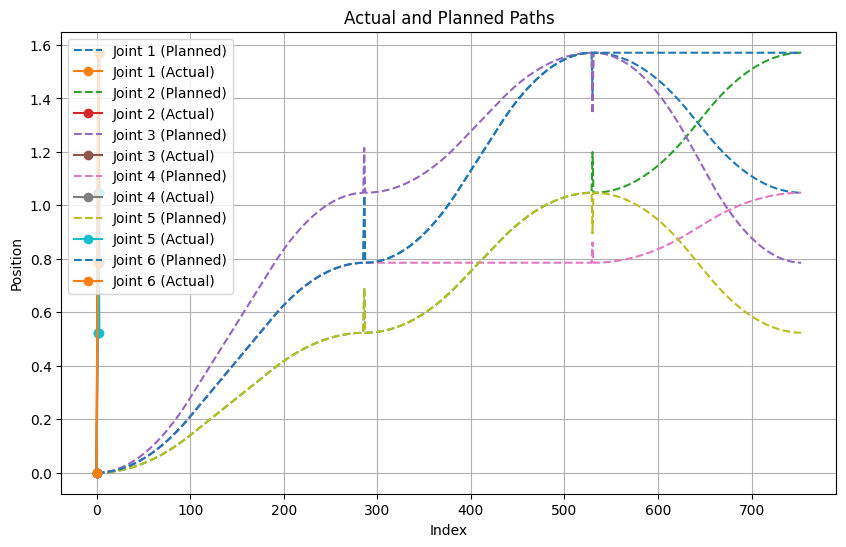

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def trapezoidal_trajectory(q0, qf, v_max, a_max, delta_t):
    """
    Generate trapezoidal trajectory between two points.
    """
    # Calculate distance and time for acceleration phase
    d_acc = 0.5 * v_max**2 / a_max
    t_acc = v_max / a_max

    # Check if the distance allows for acceleration phase
    if np.linalg.norm(qf - q0) < 2 * d_acc:
        raise ValueError("Distance too short for trapezoidal trajectory")

    # Calculate the time for constant velocity phase
    d_constant = np.linalg.norm(qf - q0) - 2 * d_acc
    t_constant = d_constant / v_max

    # Total time for the trajectory
    total_time = 2 * t_acc + t_constant

    # Time vector
    t = np.arange(0, total_time, delta_t)

    # Calculate the trajectory
    trajectory = []
    for ti in t:
        if ti <= t_acc:
            q = q0 + 0.5 * a_max * ti**2 * (qf - q0) / np.linalg.norm(qf - q0)
        elif ti <= t_acc + t_constant:
            q = q0 + d_acc * (qf - q0) / np.linalg.norm(qf - q0) + v_max * (ti - t_acc) * (qf - q0) / np.linalg.norm(qf - q0)
        else:
            q = qf - 0.5 * a_max * (total_time - ti)**2 * (qf - q0) / np.linalg.norm(qf - q0)
        trajectory.append(q)

    return np.array(trajectory)

def blend_points(p0, p1, p2, blend_factor):
    """
    Blend between two points with a given blend factor.
    """
    return (1 - blend_factor)**2 * p0 + 2 * blend_factor * (1 - blend_factor) * p1 + blend_factor**2 * p2

def generate_trajectory(points, v_max, a_max, delta_t):
    """
    Generate trajectory between multiple points.
    """
    trajectory = []
    for i in range(len(points) - 1):
        p0 = points[i]
        p1 = points[i + 1]
        p2 = points[i + 2] if i + 2 < len(points) else p1

        # Compute blending factor
        blend_factor = min(1, np.linalg.norm(p1 - p0) / (np.linalg.norm(p0 - p1) + np.linalg.norm(p1 - p2)))

        # Generate trajectory between p0 and p1
        traj_segment = trapezoidal_trajectory(p0, p1, v_max, a_max, delta_t)

        # Blend with the next point
        if i < len(points) - 2:
            traj_segment[-1] = blend_points(p1, traj_segment[-1], points[i + 2], blend_factor)

        trajectory.extend(traj_segment)

    return np.array(trajectory)

# Example inputs
points = np.array([
    [0, 0, 0, 0, 0, 0],
    [np.pi/4, np.pi/6, np.pi/3, np.pi/4, np.pi/6, np.pi/4],
    [np.pi/2, np.pi/3, np.pi/2, np.pi/4, np.pi/3, np.pi/2],
    [np.pi/3, np.pi/2, np.pi/4, np.pi/3, np.pi/6, np.pi/2]
])
v_max = 1.0  # Maximum velocity
a_max = 1.0  # Maximum acceleration
delta_t = 0.01  # Time step for trajectory generation

# Generate trajectory
trajectory = generate_trajectory(points, v_max, a_max, delta_t)

# Plot the actual and planned paths
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(trajectory[:, i], label=f'Joint {i+1} (Planned)', linestyle='--')
    plt.plot(points[:, i], label=f'Joint {i+1} (Actual)', marker='o')
plt.xlabel('Index')
plt.ylabel('Position')
plt.title('Actual and Planned Paths')
plt.legend()
plt.grid(True)
plt.show()


**What challenges are presented in such approaches? Why won’t they be 100% accurate?**

- Trapezoidal trajectories with blending aim to smoothly transition between multiple points, but determining the appropriate blending factors can be challenging, especially when dealing with complex geometries or obstacles, and comprimising the accuracy of reaching the desired points.

Generating trajectories for manipulators to reach specified path points using high-order polynomials presents several drawbacks:

- Polynomial profiles and trapezoidal trajectories may not always consider singularity and collision avoidance constraints, which are crucial for ensuring the safety and stability of the robot during motion.
- Limited Velocity Control: Initial and final velocities cannot be directly controlled.
- Increased Oscillations: Higher-order polynomials exhibit more oscillatory behavior, leading to unnatural trajectories.
- Reduced Numerical Accuracy: Higher-order polynomials require more computation, decreasing numerical accuracy.
- Complex Constraint Equations: Solving systems of constraint equations becomes more difficult with higher-order polynomials.
- Dependency on Assigned Points: Coefficients of the polynomial depend on all assigned points, requiring re-computation if any point changes.